# Prosup DTM Binary Classifier

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from keras.models import load_model
from random import choice

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'}>

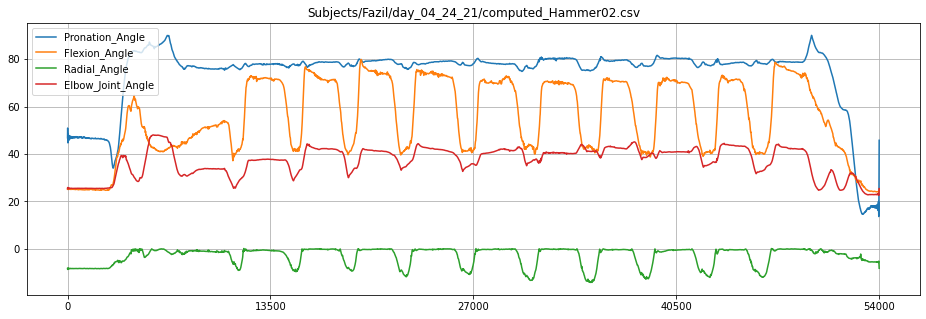

In [2]:
file = 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv'
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

In [ ]:
df = df[13500:27000]

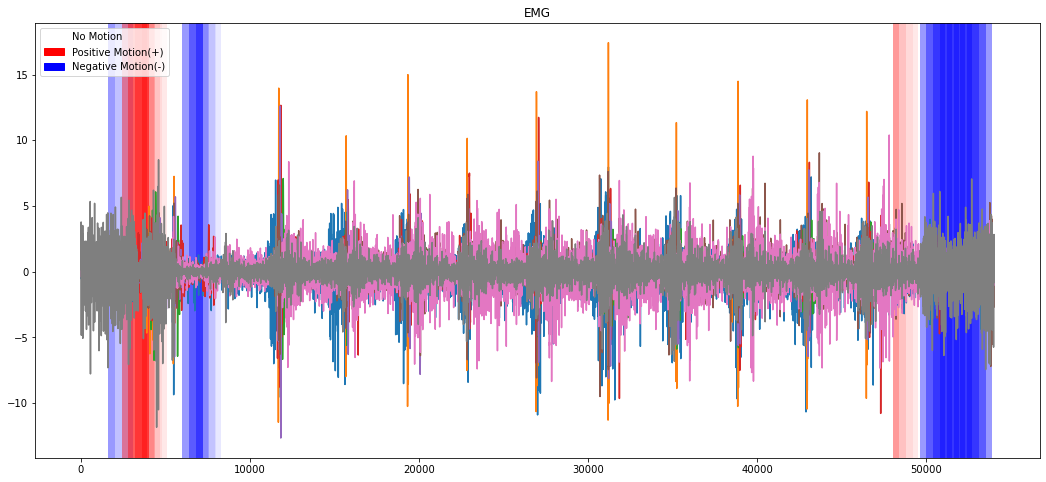

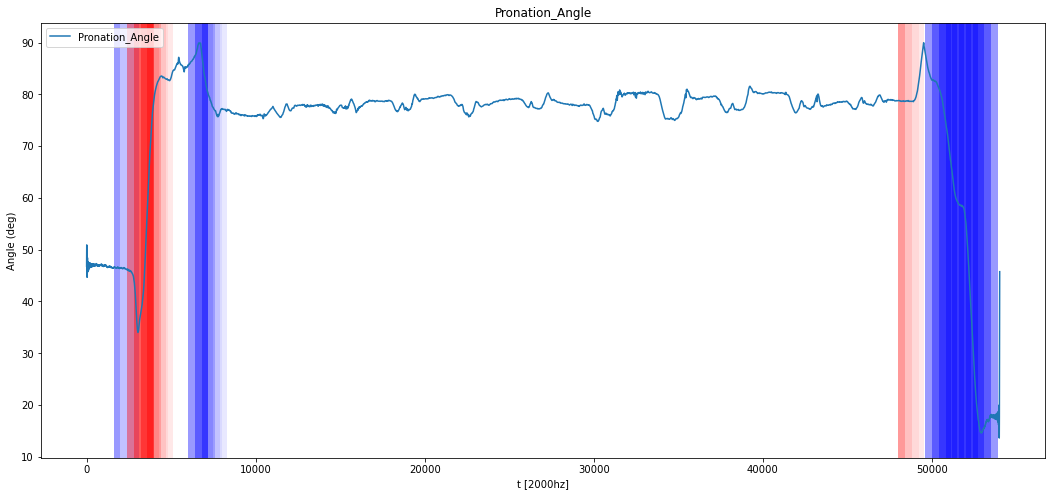

0 -> 87.12121212121212 %
1 -> 3.787878787878788 %
2 -> 9.090909090909092 %


(132, 1500, 8)

In [3]:
X, y = prep_data_prosup(df,1500,interval=400,Normalize=True,plot=True,angle_thresh=0.005,rms=False)
X.shape

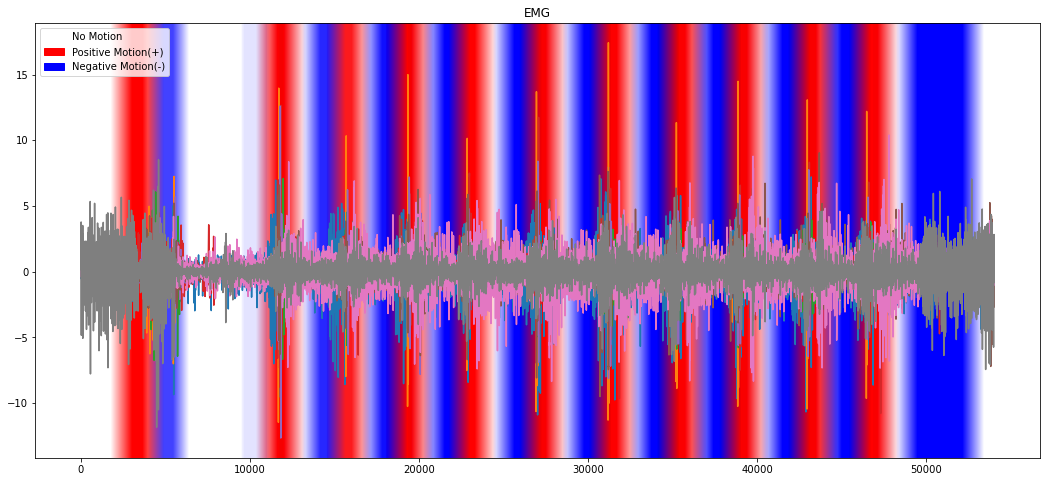

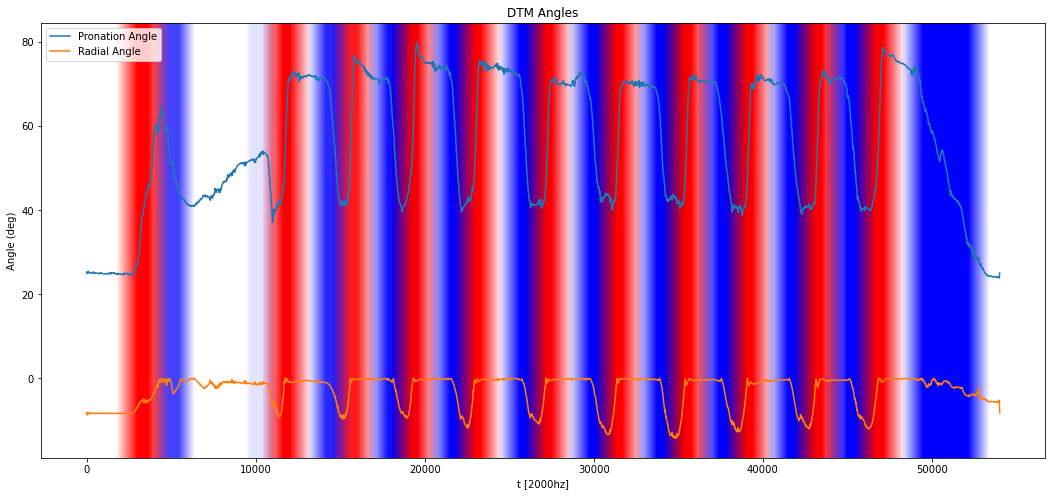

0 -> 37.86666666666667 %
1 -> 29.17142857142857 %
2 -> 32.96190476190476 %


(10500, 1500, 8)

In [4]:
X, y = prep_data_DTM(df,1500,interval=5,Normalize=True,plot=True,angle_thresh=0.008,rms=False)
X.shape

## File Name Generation

In [ ]:
files = []
path = 'Subjects/Fazil/day_04_24_21'
# trial_names = ['Hammer','Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup','Screw']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

In [ ]:
path = 'Subjects/Fazil/day_04_14_21'
# trial_names = ['Hammer','Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
trial_names = ['Bulb','Hammer' ,'Cup']
for exp in trial_names:
    for i in range(3):
        if(i==0):
            files.append(path+'/computed_'+exp+'.csv')
        else:
            files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

In [ ]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

## Data Augumentation

In [ ]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG8','EMG7']

In [ ]:
files_df_aug = []

for df in tqdm(files_df):
    theta = choice(np.linspace(0,0.4,10))
    emg_array = np.array(add_noise(df[emg_labels],theta))
    df[emg_labels] = emg_array
    files_df_aug.append(df)

In [ ]:
files_df = files_df + files_df_aug

## Data Prep Pipeline

### Parameters

In [ ]:
window = 400
interval = 5
Normalize = True
rms = True
angle_thresh_prosup = 0.01
angle_thresh_DTM = 0.008

In [ ]:
X_prosup, y_prosup = multiple_prep_data_prosup(files_df,
                                               window,
                                               interval,
                                               Normalize,
                                               rms,
                                               angle_thresh_prosup)

In [ ]:
X_dtm, y_dtm = multiple_prep_data_DTM(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh_DTM)

## Labels Modification Function

In [ ]:
def merge_X_y(X_prosup, y_prosup,X_dtm, y_dtm):
    """
    0 - Pro/Sup
    1 - DTM
    """
    y = []
    
    X = []
    
    for i in tqdm(range(len(y_prosup))):
        if(y_prosup[i][0]!=1):
            y.append([1,0])
            X.append(X_prosup[i])
            
    for i in tqdm(range(len(y_dtm))):
        if(y_dtm[i][0]!=1):
            y.append([0,1])
            X.append(X_dtm[i])
            
    y = np.array(y)
    X = np.array(X)
    print(X.shape,y.shape)
    return X, y

In [ ]:
X, y = merge_X_y(X_prosup, y_prosup,X_dtm, y_dtm)

In [ ]:
np.save('prepared_data/X',X)
np.save('prepared_data/y',y)

In [ ]:
X = np.load('prepared_data/X.npy')
y = np.load('prepared_data/y.npy')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

In [ ]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [ ]:
def count(y):
    s0 = 0
    s1 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
    ls = [s0,s1]
    for i in range(2):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [ ]:
print(count(y_train))
print(count(y_test))

# InceptionTime Trainer

In [ ]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

## Build Model

In [ ]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=2,
                            verbose=True,batch_size=136,nb_epochs=25,nb_filters=16,
                            depth=8, kernel_size=11)

In [ ]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

In [ ]:
best_model = load_model('best_model.hdf5')
best_model.save('models/binary_model_{}'.format(window))

In [ ]:
clf.model = load_model('best_model.hdf5')
clf.model.summary()

## Plot Results

In [ ]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [ ]:
metrics_df

In [ ]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
import os
os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")